In [ ]:
!pip install keras_cv
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd

  Using cached keras_cv-0.8.2-py3-none-any.whl (613 kB)
  Using cached keras_core-0.1.7-py3-none-any.whl (950 kB)
  Using cached namex-0.0.8-py3-none-any.whl (5.8 kB)
Using TensorFlow backend


In [ ]:
model = keras.models.load_model('EfficientNetV2S_finetuned.keras')

(ds_test, ds_val, ds_train), ds_info = tfds.load('stanford_dogs', split= ["test[0%:50%]", "test[50%:]", "train"], shuffle_files=True, data_dir='tensorflow_datasets/', as_supervised=True, with_info=True)

image_size = (384, 384)
batch_size = 32

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 1), augmentations_per_image=3, magnitude=0.5, rate=0.9090909090909091)

def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, image_size, method='nearest')
  image = image / 255.
  label = tf.one_hot(label, 120)
  return image, label

def augment(image, label):
  image = rand_augment(image)
  return image, label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.map(
    augment, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.batch(batch_size)
ds_val= ds_val.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling tensorflow_datasets/stanford_dogs/0.2.0.incomplete4KNZ72/stanford_dogs-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling tensorflow_datasets/stanford_dogs/0.2.0.incomplete4KNZ72/stanford_dogs-test.tfrecord*...:   0%|     …

Dataset stanford_dogs downloaded and prepared to tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
y_pred = model.predict(ds_test)
y_pred = np.argmax (y_pred, axis = 1)
y_test = np.concatenate([y for x, y in ds_test], axis=0)
y_test = np.argmax(y_test, axis=1)

135/135 [==============================] - 60s 362ms/step


In [ ]:
with open('labels.txt', 'r') as f:
    lines = f.readlines()

labels= []
for line in lines:
  line = line.split('-')[1]
  line = line.split('\n')[0]
  labels.append(line)

print(labels)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft', 'West_Highland_white_terrier', 'Lhasa', 'flat', 'curly', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'Germa

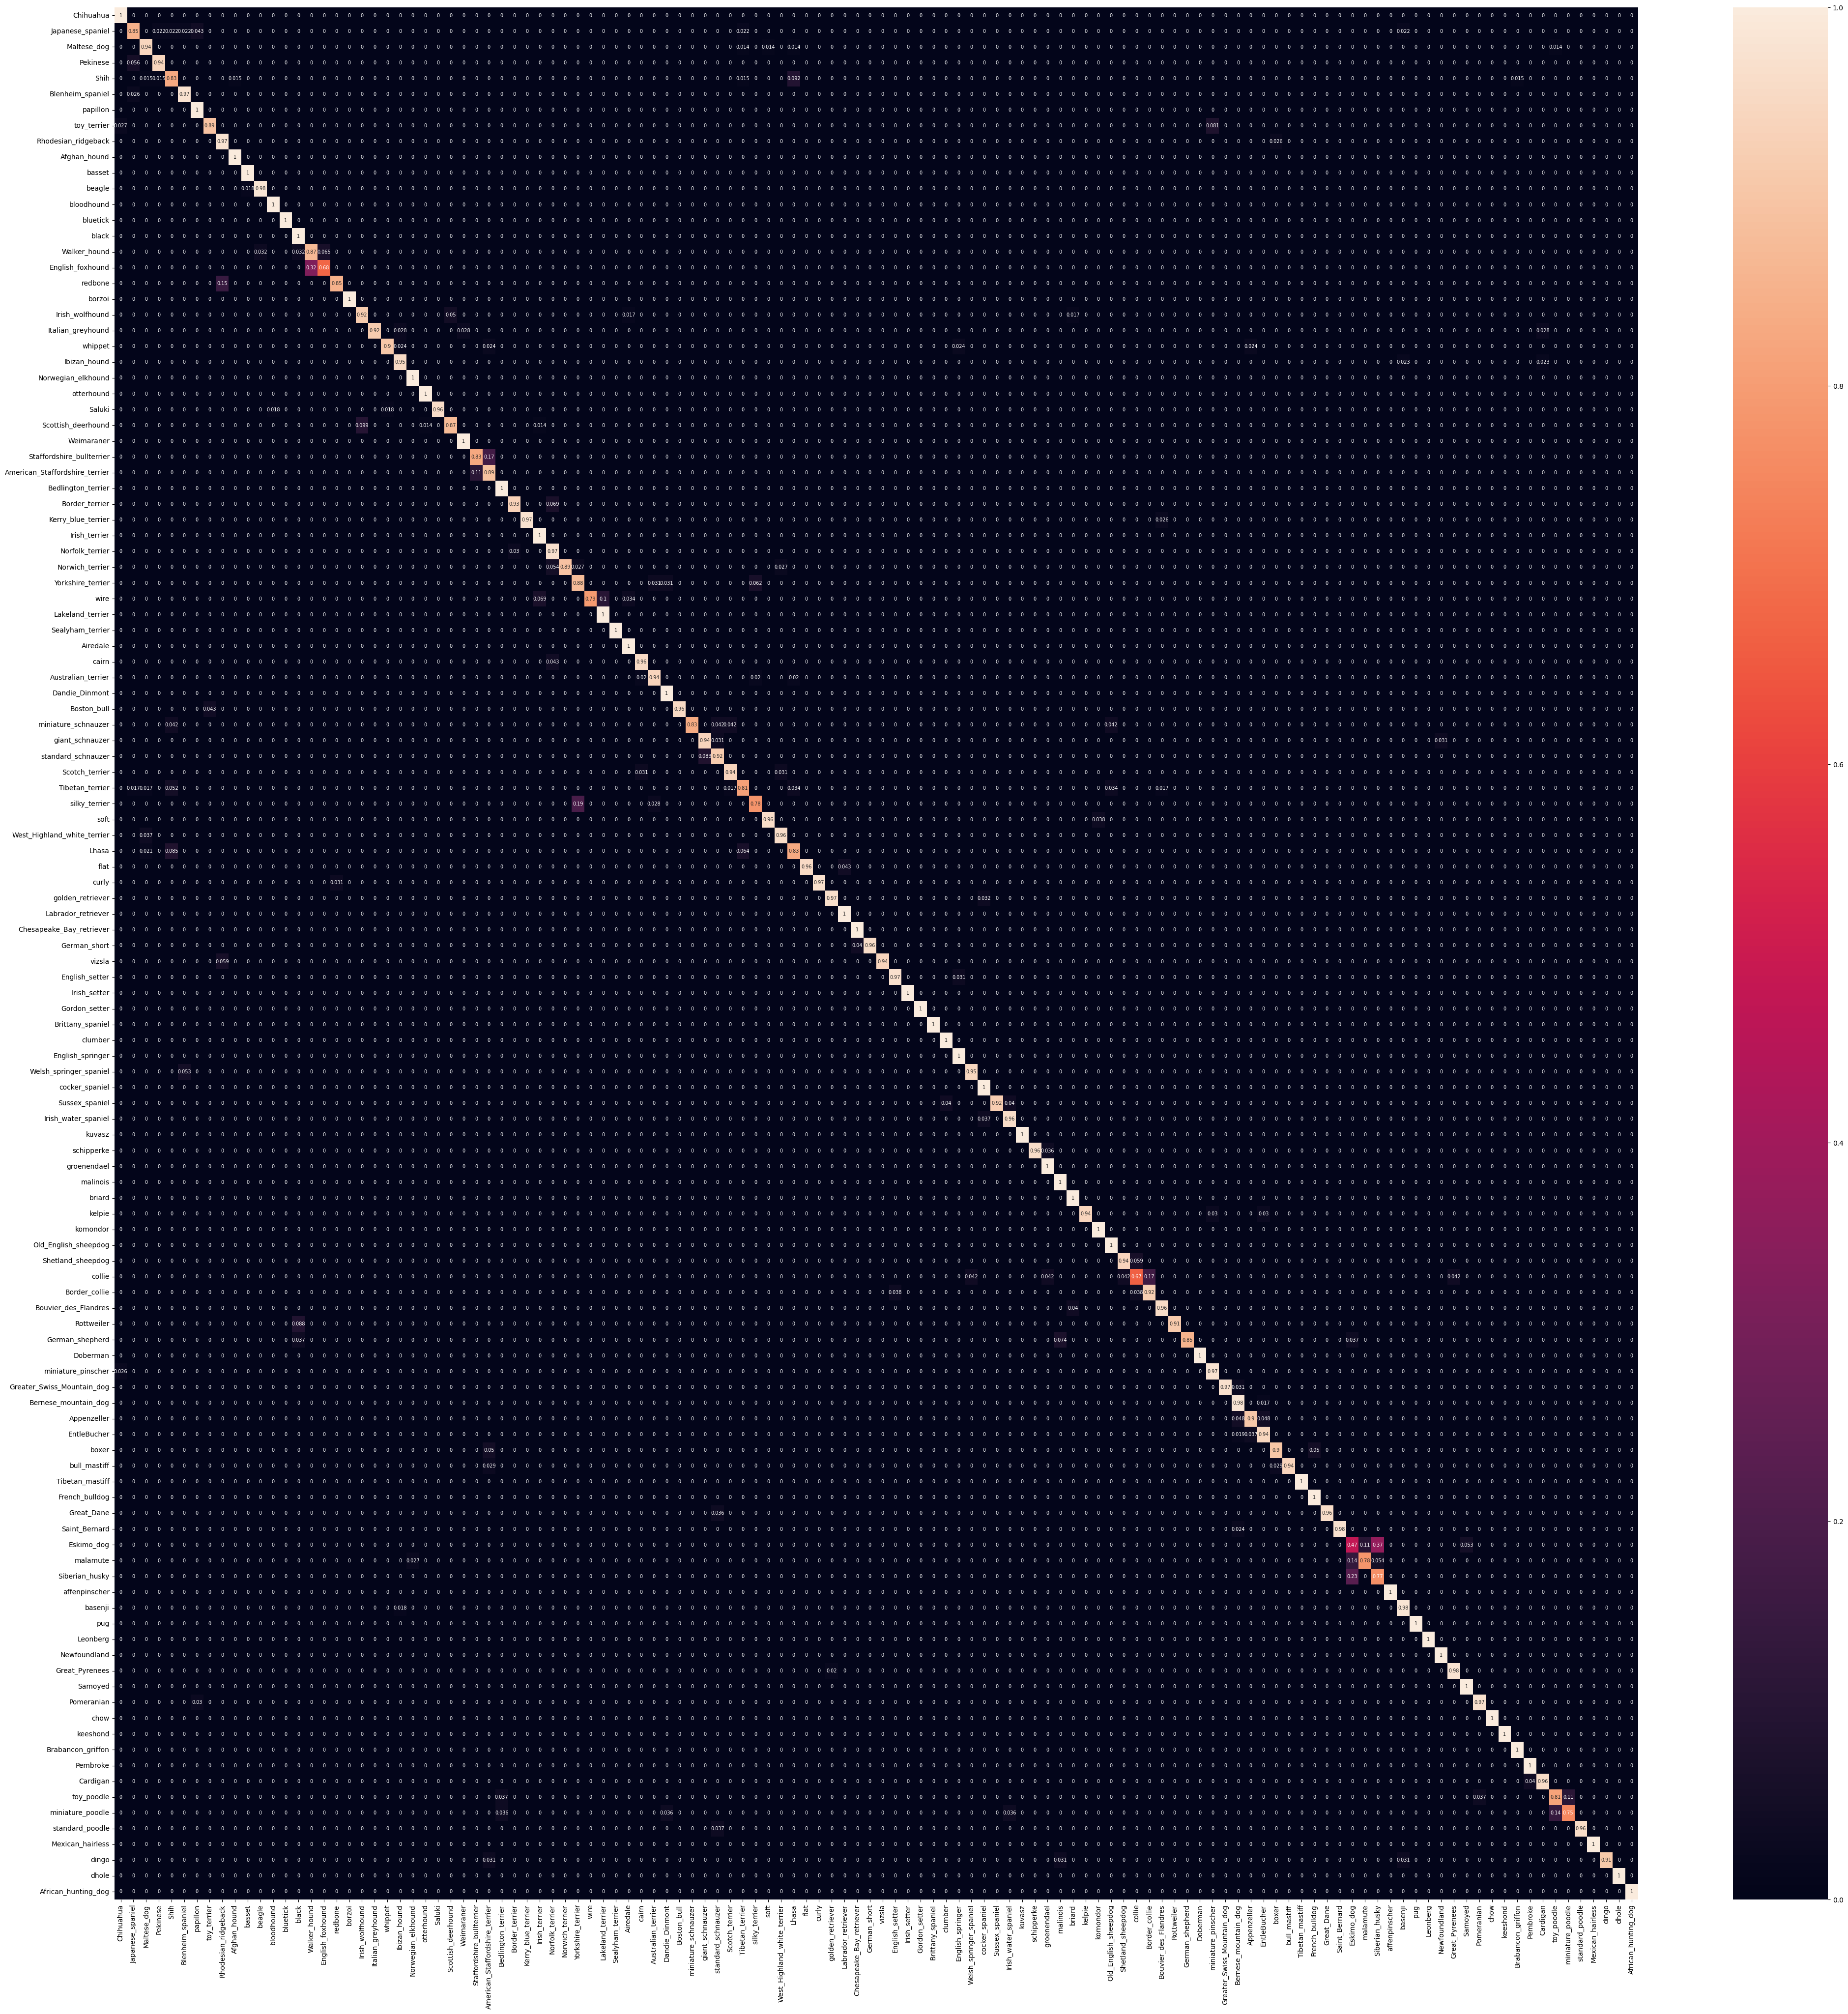

In [ ]:
result = confusion_matrix(y_test, y_pred, normalize='true')
df_cm = pd.DataFrame(result, labels, labels)
plt.figure(figsize = (50,50))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7})

plt.savefig('matrix.png')


In [ ]:

def count_classes_above_threshold(df_cm, threshold):
    # Calculate the sum of each row
    row_sums = df_cm.sum(axis=1)

    # Extract the diagonal values (true positives for each class)
    diagonal_values = pd.Series(np.diag(df_cm), index=df_cm.index)

    # Calculate accuracy as the fraction of diagonal value over row sum
    accuracy = diagonal_values / row_sums

    # Find classes above the accuracy threshold
    classes_above_threshold = accuracy > threshold

    # Count the number of classes with accuracy above the threshold
    number_of_classes_above_threshold = classes_above_threshold.sum()

    return number_of_classes_above_threshold

print("Classes above 95% accuracy:", count_classes_above_threshold(df_cm, 0.95))
print("Classes above 90% accuracy:", count_classes_above_threshold(df_cm, 0.90))
print("Classes above 85% accuracy:", count_classes_above_threshold(df_cm, 0.85))


Classes above 95% accuracy: 75
Classes above 90% accuracy: 96
Classes above 85% accuracy: 104


In [ ]:
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

print("Precision:", precision, "Recall:", recall, "F1 score:", f1)

Precision: 0.9460773183870181 Recall: 0.9438228438228439 F1 score: 0.9438212591289308


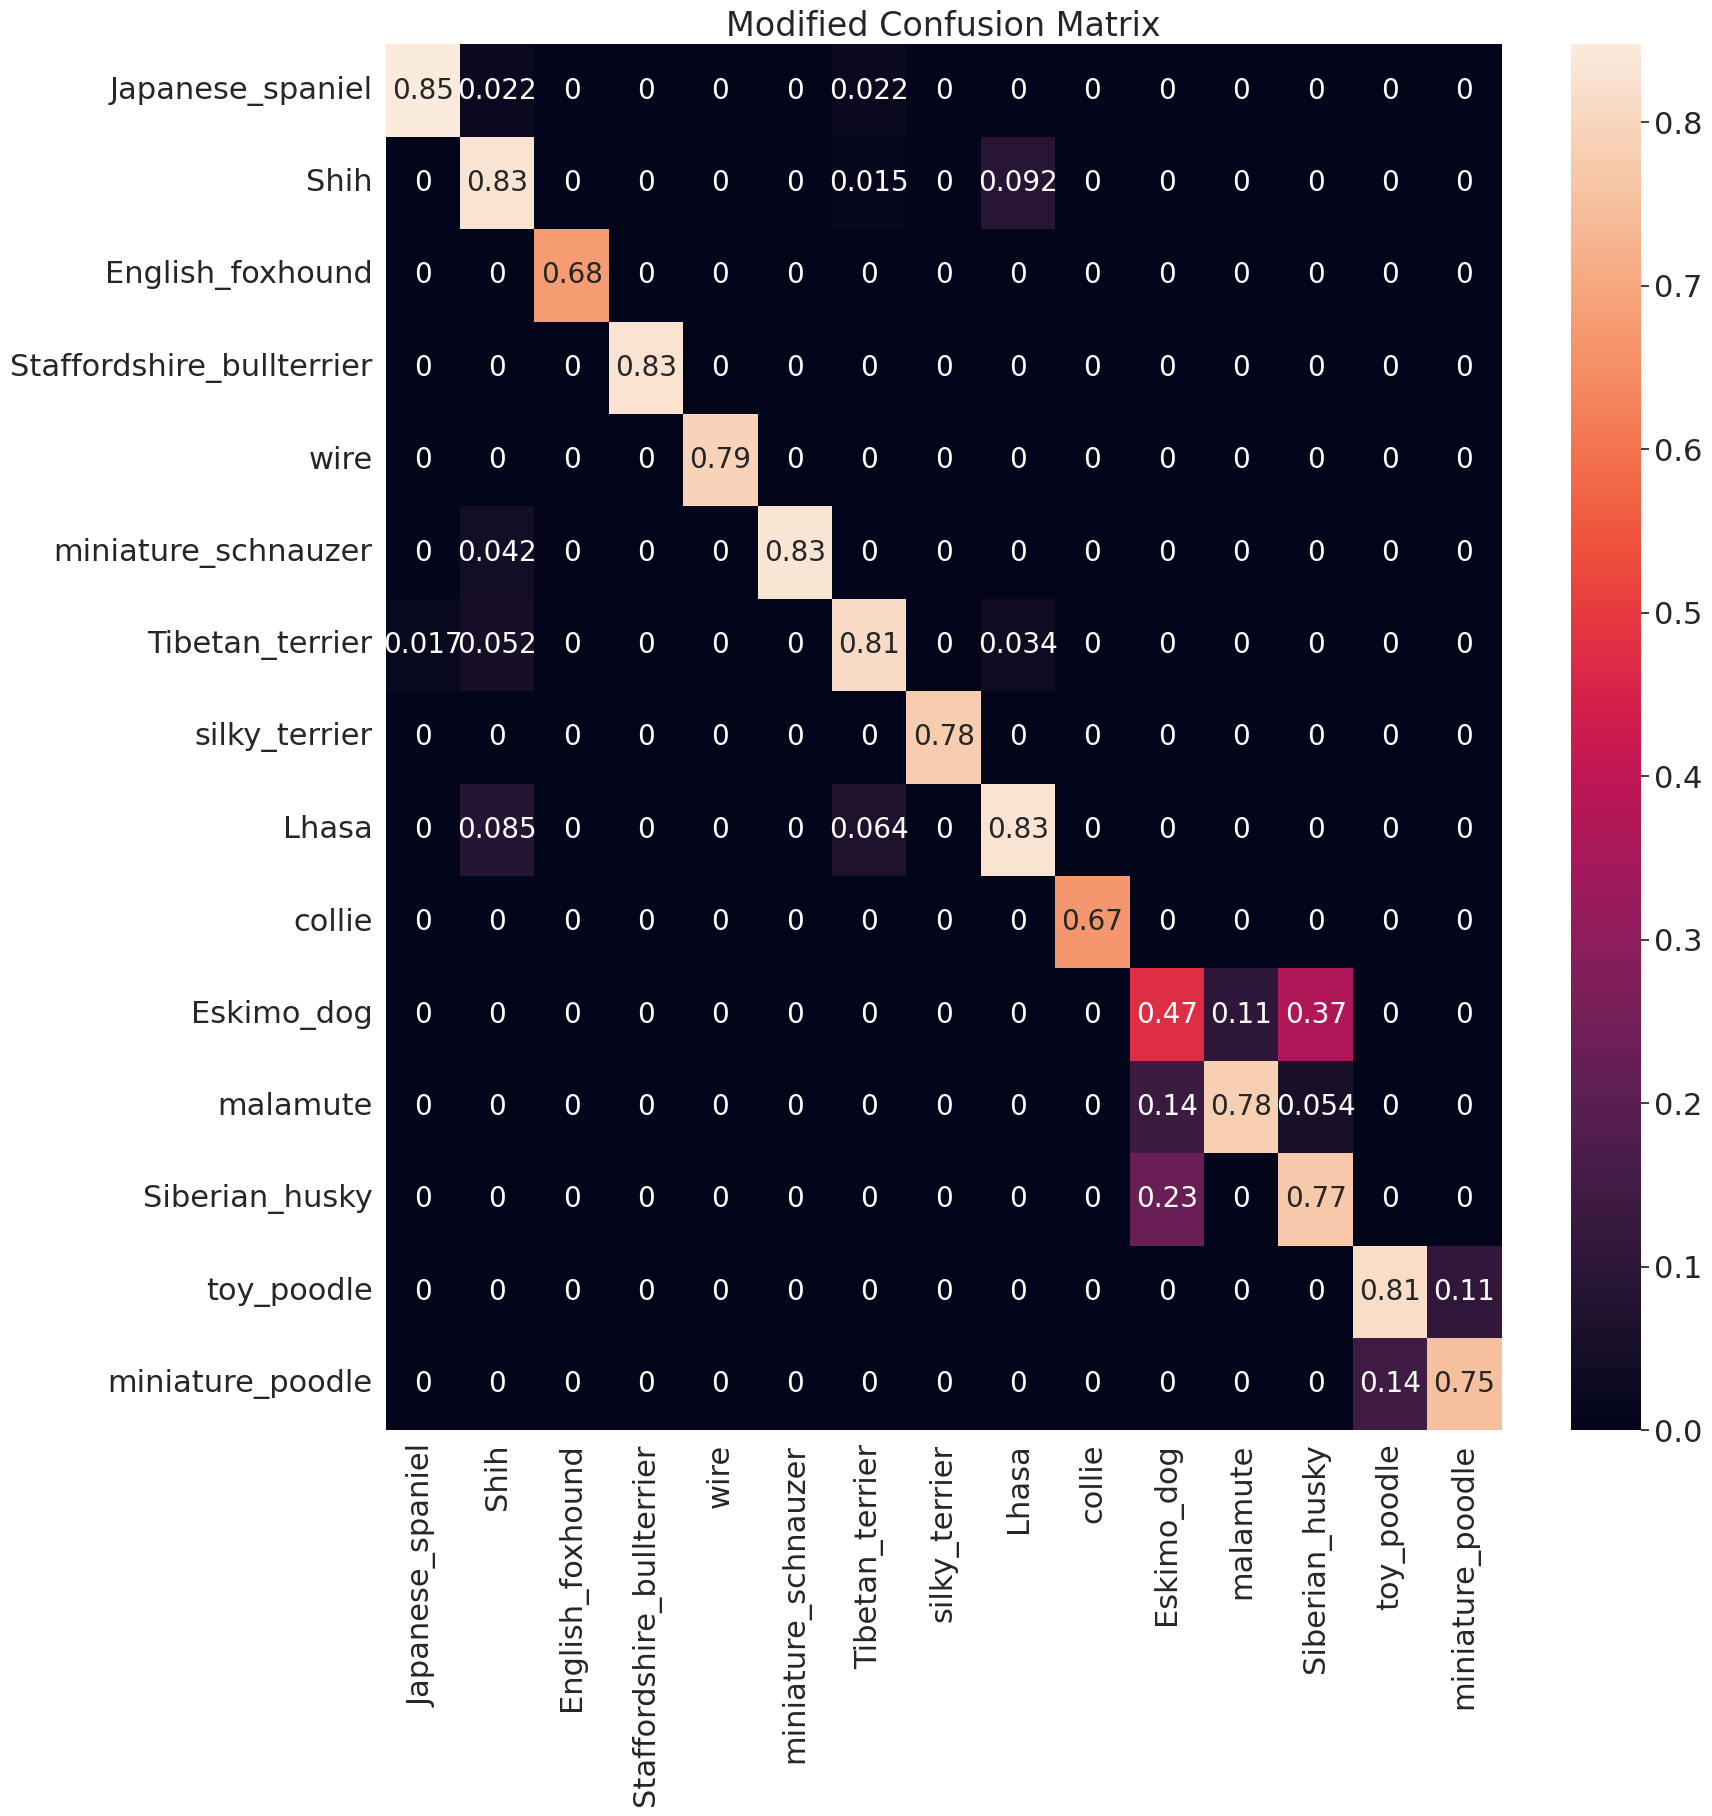

In [ ]:
threshold_accuracy = 0.85

# Identify classes with high accuracy
classes_to_remove = []
for i, row in enumerate(result):
    if row[i] >= threshold_accuracy:
        classes_to_remove.append(i)

# Create a list of indices to keep (exclude high-accuracy classes)
indices_to_keep = [i for i in range(result.shape[0]) if i not in classes_to_remove]

# Create a new matrix with relevant rows and columns
filtered_result = result[indices_to_keep][:, indices_to_keep]

# Get class labels for the remaining classes
filtered_labels = [labels[i] for i in indices_to_keep]

# Create a DataFrame for the modified confusion matrix
df_cm = pd.DataFrame(filtered_result, filtered_labels, filtered_labels)

# Plot the heatmap
sn.set(font_scale=2)
plt.figure(figsize=(18, 18))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20})
plt.title("Modified Confusion Matrix")
plt.savefig('modified_matrix_with_labels.png')